# Import

In [ ]:

# Import Library
import torch
torch.cuda.empty_cache()
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torchvision
from torchvision import models,transforms

from collections import namedtuple

from sklearn.metrics import classification_report

import time

# Get DATA

In [ ]:
# Using CUDA
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")
else: print("Using CPU")

Using CUDA


In [ ]:
# Clone Data
!git clone https://github.com/qcuong103/echocardiography

# Hyper-parameters
classes = ['2C', '3C', '4C']
TrainTest = namedtuple('TrainTest', ['train', 'test'])

fatal: destination path 'echocardiography' already exists and is not an empty directory.


# Prepare Data

In [ ]:
# Transforms Data
def prepare_data(sizeImg=224, typeImg="None"):
  if (typeImg == "None"):
    if (sizeImg == 224):
      transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()])
      transform_test = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()])
    elif (sizeImg == 64):
      transform_train = transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor()])
      transform_test = transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor()])
    else:
      transform_train = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor()])
      transform_test = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor()])
  elif (typeImg == "aug"):
    transform_train = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.RandomHorizontalFlip(p=0.3),
      transforms.RandomVerticalFlip(p=0.3),
      transforms.RandomRotation(degrees=10),
      transforms.ToTensor()])
    transform_test = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor()])
  else:
    transform_train = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.RandomEqualize(p=1),
      transforms.GaussianBlur(kernel_size=3),
      transforms.ToTensor()])
    transform_test = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.RandomEqualize(p=1),
      transforms.GaussianBlur(kernel_size=3),
      transforms.ToTensor()])
    
  trainset = torchvision.datasets.ImageFolder(
      root='/content/echocardiography/DATA_CHAMBER_2021/train', 
      transform=transform_train)
  testset = torchvision.datasets.ImageFolder(
      root='/content/echocardiography/DATA_CHAMBER_2021/test', 
      transform=transform_test)
  
  print("Number of Image in train set:", len(trainset))
  print("Number of Image in test set:", len(testset))

  return TrainTest(train=trainset,test=testset)

# Load Data
def prepare_loader(datasets):
  batch_size = 32
  trainloader = DataLoader(
    dataset=datasets.train, batch_size=batch_size, 
    shuffle=True, num_workers=4
  )
  testloader = DataLoader(
    dataset=datasets.test, batch_size=batch_size, 
    shuffle=True, num_workers=4
  )
  
  print("Num batch in train set: ", len(trainloader))
  print("Num batch in test set: ", len(testloader))
  class_names = datasets.train.classes
  inputs, classes = next(iter(trainloader))
  # show_databatch(inputs, classes)
  for i in range(4):
    print([class_names[x] for x in classes[(8*i):(8*i+8)]])
  imshow(torchvision.utils.make_grid(inputs))
  return TrainTest(train=trainloader, test=testloader)

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# dataset = prepare_data()
# loaderset = prepare_loader(dataset)

In [ ]:
torch.__version__

'1.10.0+cu111'

# **Train**

In [ ]:
def train_epoch(epoch, model, loader, loss_func, optimizer, device):
  print("Train model")
  print('-' * 10)
  model.train()
  running_loss = 0.0
  images_so_close = 0.0
  reporting_steps = 60

  for i, (images, labels) in enumerate(loader):
    images, labels = images.to(device), labels.to(device)
    
    optimizer.zero_grad()
    outputs = model(images)
    loss = loss_func(outputs, labels)
    loss.backward()
    optimizer.step()

    images_so_close = loss.item()
    running_loss += images_so_close
    if i % reporting_steps == reporting_steps - 1:
      print(f"Epoch {epoch} Step {i} ave_loss {running_loss/reporting_steps:.4f}")
      running_loss = 0.0
  return images_so_close


# **Test**

In [ ]:
def test_epoch(epoch, model, loader, device):
  since = time.time()

  model.eval()
  ytrue = []
  ypred = []

  print("Test model")
  print('-' * 10)

  for i, (images, labels) in enumerate(loader):
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs, dim=1)
    ytrue += list(labels.cpu().numpy())
    ypred += list(predicted.cpu().numpy())

  elapsed_time = time.time() - since
  print()
  print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
  print('-' * 10)

  return ypred, ytrue

# **Main**

In [ ]:
def run(modelName, imgSize, aug):
  PATH = "./" + modelName + '.pth'
  datasets = prepare_data(imgSize, aug)
  loaders = prepare_loader(datasets)
  use_pretrained = False
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print("image size: ", datasets.train[0][0].shape)
  print("device:", device)
  print("model:", modelName)
  
  if modelName == 'vgg16':
    model = models.vgg16(pretrained=use_pretrained)
    model.classifier[6] = nn.modules.linear.Linear(in_features=4096, out_features=3, bias=True)
  elif modelName == 'resnet50':
    model = models.resnet50(pretrained=use_pretrained)
    model.fc = nn.modules.linear.Linear(in_features=2048, out_features=3, bias=True) 
  elif modelName == 'resnet18':
    model = models.resnet18(pretrained=use_pretrained)
    model.fc = nn.modules.linear.Linear(in_features=512, out_features=3, bias=True)
  else:
    model = models.densenet121(pretrained=use_pretrained)
    model.classifier = nn.modules.linear.Linear(in_features=1024, out_features=3, bias=True)
  model.to(device)

  loss_func = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

  # class_out = len(classes)
  n_epoch = 20

  accuracies = []
  losses = []
  for epoch in range(n_epoch):
    print("---------------------------------------------------------------")
    print(f"\nEpoch {epoch} report: ")
    loss = train_epoch(epoch, model, loaders.train, loss_func, optimizer, device)
    ypred, ytrue = test_epoch(epoch, model, loaders.test, device)

    print("Test report: \n", classification_report(ytrue, ypred, target_names=classes))
    
    torch.save(model.state_dict(), PATH)

    ypred = np.array(ypred)
    ytrue = np.array(ytrue)
    accuracy = int((ytrue==ypred).sum() / len(ytrue) * 100)
    accuracies.append(accuracy)
    losses.append(round(loss, 4))

  print("model:", modelName, ", size:", imgSize, ", augmentation:", aug)
  print("accr: ", accuracies)
  print("loss: ", losses)
  return model

# **Run**

Number of Image in train set: 6717
Number of Image in test set: 1607
Num batch in train set:  210
Num batch in test set:  51


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


['3C', '3C', '2C', '3C', '3C', '4C', '3C', '3C']
['3C', '3C', '2C', '4C', '3C', '3C', '3C', '3C']
['4C', '4C', '2C', '4C', '2C', '4C', '4C', '4C']
['4C', '4C', '4C', '4C', '3C', '2C', '3C', '4C']


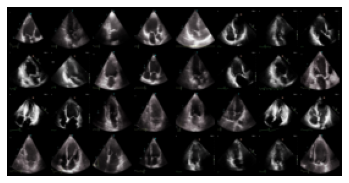

image size:  torch.Size([3, 32, 32])
device: cuda
model: vgg16
---------------------------------------------------------------

Epoch 0 report: 
Train model
----------
Epoch 0 Step 59 ave_loss 1.0968
Epoch 0 Step 119 ave_loss 1.0476
Epoch 0 Step 179 ave_loss 0.7016


In [ ]:
modelset = ['vgg16', 'resnet18', 'resnet50', 'densenet121']

for i in modelset:
  model = run(modelName=i, imgSize=224, aug="None")

# Demo mô hình với video

In [ ]:
def run_video(modelName = 'vgg16'):
  transform_test = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()])
  sample_data = torchvision.datasets.ImageFolder(
      root='/content/echocardiography/DATA_CHAMBER_2021/test', 
      transform=transform_test)
  videotest = namedtuple('videotest', ['id', "ytrues", 'ypreds'])
  id_video = []

  for i, image in enumerate(sample_data.imgs):
    id_video.append(image[0].split("/")[-1].split("_")[0])
  
  video_list = []
  for image in id_video:
    if (image in video_list) == False:
      video_list.append(image)
    else:
      pass

  ytrue = []
  ypred = []

  if modelName == 'vgg16':
    modelload = torchvision.models.vgg16(pretrained=False)
    modelload.classifier[6] = torch.nn.modules.linear.Linear(in_features=4096, out_features=3, bias=True)
    modelload.load_state_dict(torch.load('vgg16.pth'), strict=False)
  elif modelName == "resnet50":
    modelload = torchvision.models.resnet50(pretrained=False)
    modelload.fc = torch.nn.modules.linear.Linear(in_features=2048, out_features=class_out, bias=True) 
    modelload.load_state_dict(torch.load('resnet50.pth'))
  elif modelName == "resnet18":
    modelload = torchvision.models.resnet50(pretrained=False)
    modelload.fc = torch.nn.modules.linear.Linear(in_features=512, out_features=class_out, bias=True) 
    modelload.load_state_dict(torch.load('resnet18.pth'))
  else:
    modelload = torchvision.models.densenet121(pretrained=False)
    modelload.classifier = torch.nn.modules.linear.Linear(in_features=1024, out_features=class_out, bias=True)
    modelload.load_state_dict(torch.load('densenet121.pth'))

  modelload.to('cuda')
  modelload.eval()
  for image, label in sample_data:
    image = image.unsqueeze(0).to('cuda')
    output = modelload(image)
    _, predicted = torch.max(output, dim=1)
    ytrue.append(label)
    ypred += list(predicted.cpu().numpy())

  outputs_video = []
  ytrue_video = []
  ypred_video = []
  index = 0
  for id in video_list:
    index += 1
    vtrue = []
    vpred = []
    for i, img in enumerate(id_video):
      if img == id:
        vtrue.append(ytrue[i])
        vpred.append(ypred[i])

    rate_true = [0, 0, 0]
    rate_pred = [0, 0, 0]
    for label in range(3):
      rate_true[label] = list(vtrue).count(label)
      rate_pred[label] = list(vpred).count(label)

    labeltrue = np.argmax(rate_true)
    labelpred = np.argmax(rate_pred)

    if index %4 != 0:
      print("id: ", id, ", true:", labeltrue, ", pred: ", labelpred, end="  |  ")
    else: print("id: ", id, ", true:", labeltrue, ", pred: ", labelpred)
    ytrue_video.append(labeltrue)
    ypred_video.append(labelpred)
    outputs_video.append(videotest(id=id,ytrues=labeltrue,ypreds=labelpred))
  print(classification_report(ytrue_video, ypred_video, target_names=classes))
  return outputs_video

In [ ]:
# result = run_video('vgg16')
for i in modelset:
  result = run_video(modelName=i)

In [ ]:
# for i in range(len(result)):
#   if (i+1)%3!=0:
#     print(result[i], end="  |  ")
#   else: print(result[i])

In [ ]:
import pandas as pd
def demo_frame(modelName='vgg16')
  transform_test = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()])
  sample_data = torchvision.datasets.ImageFolder(
      root='/content/echocardiography/DATA_CHAMBER_2021/test', 
      transform=transform_test)
  filename = []
  for i, image in enumerate(sample_data.imgs):
    filename.append(image[0].split("/")[-1])
    # print(image[0].split("/")[-1])
  if modelName == 'vgg16':
    modelload = torchvision.models.vgg16(pretrained=False)
    modelload.classifier[6] = torch.nn.modules.linear.Linear(in_features=4096, out_features=3, bias=True)
    modelload.load_state_dict(torch.load('vgg16.pth'), strict=False)
  elif modelName == "resnet50":
    modelload = torchvision.models.resnet50(pretrained=False)
    modelload.fc = torch.nn.modules.linear.Linear(in_features=2048, out_features=class_out, bias=True) 
    modelload.load_state_dict(torch.load('resnet50.pth'))
  elif modelName == "resnet18":
    modelload = torchvision.models.resnet50(pretrained=False)
    modelload.fc = torch.nn.modules.linear.Linear(in_features=512, out_features=class_out, bias=True) 
    modelload.load_state_dict(torch.load('resnet18.pth'))
  else:
    modelload = torchvision.models.densenet121(pretrained=False)
    modelload.classifier = torch.nn.modules.linear.Linear(in_features=1024, out_features=class_out, bias=True)
    modelload.load_state_dict(torch.load('densenet121.pth'))

  modelload.to('cuda')
  modelload.eval()
  ypred = []
  for image, label in sample_data:
      image = image.unsqueeze(0).to('cuda')
      output = modelload(image)
      _, predicted = torch.max(output, dim=1)
      ypred += list(predicted.cpu().numpy())
  classes0 = {'2C':0 , '3C':1, '4C':2}
  classes0 = dict((v,k) for k,v in classes0.items())
  predictions = [classes0[k] for k in ypred]
  result0 = pd.DataFrame({"Filename":filename, "Prediction":predictions})
  results_file = "./" + modelName + "_results.csv"
  result0.to_csv(results_file,index=False)

In [ ]:
for i in modelset:
  result = demo_frame(modelName=i)